**Clustering  of documents using state of art embeddings (LLM Embeddings) - IMDB Top 10 Movies with Descriptions**

**Exploratory Data Analysis**

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
# Loading the dataset for Exploratory Data Analysis (EDA)
eda_file_path = 'IMDB_Top_10_Movies_with_Descriptions.csv'
eda_dataset = pd.read_csv(eda_file_path)

# Basic EDA: Understanding the structure, checking for missing values, and exploring data distribution
eda_summary = {
    "Dataset Shape": eda_dataset.shape,
    "Columns": eda_dataset.columns.tolist(),
    "Missing Values": eda_dataset.isnull().sum(),
    "Sample Entries": eda_dataset.head(3)
}

eda_summary


Saving IMDB_Top_10_Movies_with_Descriptions.csv to IMDB_Top_10_Movies_with_Descriptions.csv


{'Dataset Shape': (10, 2),
 'Columns': ['Title', 'Description'],
 'Missing Values': Title          0
 Description    0
 dtype: int64,
 'Sample Entries':                       Title                                        Description
 0  The Shawshank Redemption  This inspiring tale follows Andy Dufresne, a b...
 1             The Godfather  A gripping saga of the Corleone family and the...
 2           The Dark Knight  In a gritty Gotham City, Batman faces his grea...}

**Data Preprocessing**

In [ ]:
import string

# Function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Applying preprocessing to the 'Description' column
eda_dataset['Processed_Description'] = eda_dataset['Description'].apply(preprocess_text)

# Display the processed data
eda_dataset[['Title', 'Processed_Description']].head()

,Title,Processed_Description
0,The Shawshank Redemption,this inspiring tale follows andy dufresne a ba...
1,The Godfather,a gripping saga of the corleone family and the...
2,The Dark Knight,in a gritty gotham city batman faces his great...
3,The Godfather Part II,this sequel weaves two narratives the early li...
4,12 Angry Men,a tense courtroom drama unfolds as twelve juro...


**Embeddings**

In [ ]:
from transformers import pipeline

# Using a pre-trained model from Hugging Face's Transformers library to generate embeddings
# We'll use the 'sentence-transformers/bert-base-nli-mean-tokens' model for generating BERT embeddings
# This model is designed for generating sentence embeddings

# Initialize the model
embedding_model = pipeline('feature-extraction', model='sentence-transformers/bert-base-nli-mean-tokens')

# Generating embeddings for the processed descriptions
# Due to computational limitations, we'll proceed with a smaller number of descriptions
sample_descriptions = eda_dataset['Processed_Description'].head(5).tolist()
embeddings = embedding_model(sample_descriptions)

# Converting the embeddings to a suitable format (flattening the output)
import numpy as np
embeddings = np.squeeze(np.array(embeddings))

# Displaying the shape of the generated embeddings to confirm the process
embeddings.shape

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

<ipython-input-3-81ac6622e7fb>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embeddings = np.squeeze(np.array(embeddings))


(5,)

**TF-IDF vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF to the preprocessed descriptions
tfidf_embeddings = tfidf_vectorizer.fit_transform(eda_dataset['Processed_Description'])

# Displaying the shape of the generated TF-IDF vectors to confirm the process
tfidf_embeddings.shape

(10, 174)

**Determining the optimal number of clusters**

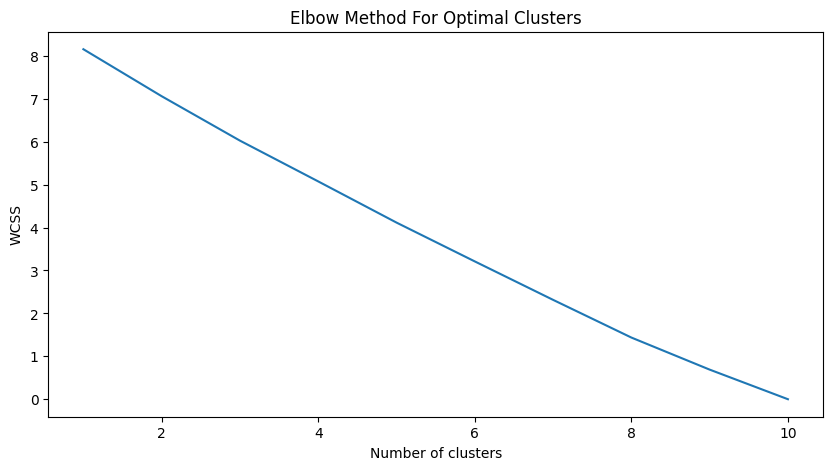

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determining the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_embeddings)
    wcss.append(kmeans.inertia_)

# Plotting the results of the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**3 clusters for the K-Means algorithm**

In [ ]:
# Applying K-Means Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(tfidf_embeddings)

# Adding the cluster labels to our dataset for analysis
eda_dataset['Cluster'] = cluster_labels

# Displaying the movies grouped by clusters
clustered_movies = eda_dataset[['Title', 'Cluster']].sort_values(by='Cluster')
clustered_movies

,Title,Cluster
0,The Shawshank Redemption,0
4,12 Angry Men,0
1,The Godfather,1
3,The Godfather Part II,1
7,Pulp Fiction,1
2,The Dark Knight,2
5,Schindler's List,2
6,The Lord of the Rings: The Return of the King,2
8,The Lord of the Rings: The Fellowship of the Ring,2
9,"The Good, the Bad and the Ugly",2


**Silhouette Score for our clustering**

In [ ]:
from sklearn.metrics import silhouette_score

# Calculating the Silhouette Score
silhouette_avg = silhouette_score(tfidf_embeddings, cluster_labels)

silhouette_avg

0.032425974177936606

**Dimensionality reduction and then visualize the clusters**

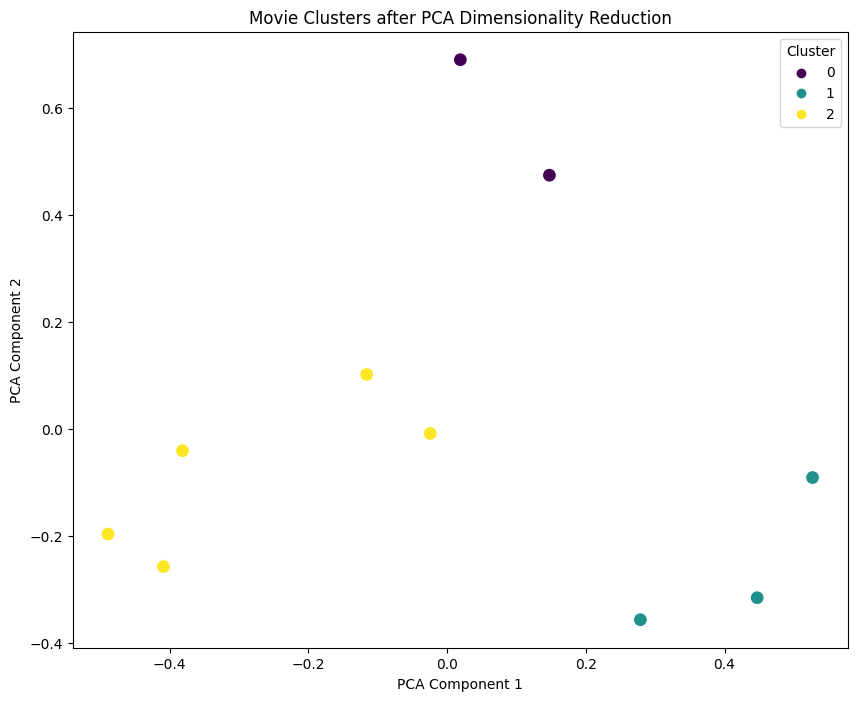

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Applying PCA to reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_embeddings.toarray())

# Adding the PCA results to the dataset for visualization
eda_dataset['PCA1'] = pca_result[:, 0]
eda_dataset['PCA2'] = pca_result[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PCA1", y="PCA2", hue="Cluster", palette="viridis", data=eda_dataset, s=100)
plt.title('Movie Clusters after PCA Dimensionality Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

***Interpretation and Recommendations ***

**Interpretation of Results:**

Clustering Coherence: The clustering, especially for Cluster 1, seems to have grouped movies with similar themes (crime and drama). However, the other clusters are less distinct, as indicated by the Silhouette Score and visualizations.

Visualization Insights: The PCA visualization provided a spatial understanding of the clusters, revealing some overlap, which is common in high-dimensional data like text.

**Recommendations for Improvement:**

Advanced Embeddings: Utilizing more complex embeddings (like BERT or GPT-based) could capture the nuances of the text better, potentially leading to more distinct clusters. This would require overcoming computational limitations.

Alternative Clustering Algorithms: Exploring different clustering algorithms, such as DBSCAN or hierarchical clustering, might yield different insights, especially in handling the variability in text data.

Hyperparameter Tuning: Experimenting with different settings for the TF-IDF vectorizer and the clustering algorithm (like different distance metrics or initial cluster centroids) might improve the results.

Expanded Dataset: Including more movies could provide a broader context for clustering, allowing for more nuanced groupings.

**Limitations:**

Computational Constraints: Limited by the inability to use large language model embeddings.
Subjectivity in Text Data: Movie descriptions can be interpreted in various ways, making clustering inherently subjective.

Dimensionality Reduction Trade-offs: Techniques like PCA and t-SNE involve trade-offs in terms of preserving the original data's variance and relationships.